Paper for [11th International Conference on Informatics in Control, Automation and Robotics (ICINCO) 2014](http://www.icinco.org/)

![ICINCO2014](http://www.icinco.org/App_Themes/2014/Images/up.png)

In [1]:
import numpy as np
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.stats import norm
import time
from IPython.display import Image as ImageDisp
from sympy import Symbol, symbols, Matrix, sin, cos, latex#, Plot
from sympy.interactive import printing
printing.init_printing()
%pylab inline --no-import-all

Populating the interactive namespace from numpy and matplotlib


# Adaptive Extended Kalman Filter Implementation for Constant Turn Rate and Velocity (CTRV) Vehicle Model with Attitude Estimation in Python

![Extended Kalman Filter Step](https://raw.github.com/balzer82/Kalman/master/Extended-Kalman-Filter-Step.png)

Situation covered: You have an velocity sensor which measures the vehicle speed ($v$) in heading direction ($\psi$) and a yaw rate sensor ($\dot \psi$) which both have to fused with the position ($x$ & $y$) from a GPS sensor in loosely coupled way.

## State Vector - Constant Turn Rate and Velocity Vehicle Model (CTRV) + Roll and Pitch Estimation

<img style="float: right; width: 400px; margin-right: 300px;" src="http://mechlab-engineering.de/ablage/Koordinatensystem-DIN70000.png" />

$$x_k= \left[ \begin{matrix} x\\y\\ v \\ \psi\\\phi\\\Theta \end{matrix}\right] = \left[ \begin{matrix} \text{Position x (GNSS)}\\ \text{Position y (GNSS)}\\ \text{Speed (GNSS)} \\ \text{Heading (GNSS)} \\ \text{Pitch (IMU)} \\ \text{Roll (IMU)} \end{matrix}\right]$$

In [2]:
numstates=6 # States

In [3]:
dt    = 1.0/50.0 # Sample Rate of the Measurements is 50Hz
dtGPS = 1.0/10.0 # Sample Rate of GPS is 10Hz

All symbolic calculations are made with [Sympy](http://nbviewer.ipython.org/github/jrjohansson/scientific-python-lectures/blob/master/Lecture-5-Sympy.ipynb). Thanks!

In [4]:
vs, psis, dpsis, dts, xs, ys, axs, phis, dphis, thetas, dthetas, Lats, Lons = \
 symbols('v \psi \dot\psi T x y a_x \phi \dot\phi \Theta \dot\Theta Lat Lon')

As = Matrix([[xs+(vs/dpsis)*(sin(psis+dpsis*dts)-sin(psis))],
             [ys+(vs/dpsis)*(-cos(psis+dpsis*dts)+cos(psis))],
             [vs + axs*dts],
             [psis+dpsis*dts],
             [phis+dphis*dts],
             [thetas+dthetas*dts]])
state = Matrix([xs,ys,vs,psis,phis,thetas])

## Dynamic Matrix

This formulas calculate how the state is evolving from one to the next time step

In [5]:
As

⎡    v⋅(-sin(\psi) + sin(T⋅\dot\psi + \psi))⎤
⎢x + ───────────────────────────────────────⎥
⎢                    \dot\psi               ⎥
⎢                                           ⎥
⎢    v⋅(cos(\psi) - cos(T⋅\dot\psi + \psi)) ⎥
⎢y + ────────────────────────────────────── ⎥
⎢                   \dot\psi                ⎥
⎢                                           ⎥
⎢                 T⋅aₓ + v                  ⎥
⎢                                           ⎥
⎢             T⋅\dot\psi + \psi             ⎥
⎢                                           ⎥
⎢             T⋅\dot\phi + \phi             ⎥
⎢                                           ⎥
⎣           T⋅\dot\Theta + \Theta           ⎦

In [6]:
print (latex(As))

\left[\begin{matrix}x + \frac{v}{\dot\psi} \left(- \sin{\left (\psi \right )} + \sin{\left (T \dot\psi + \psi \right )}\right)\\y + \frac{v}{\dot\psi} \left(\cos{\left (\psi \right )} - \cos{\left (T \dot\psi + \psi \right )}\right)\\T a_{x} + v\\T \dot\psi + \psi\\T \dot\phi + \phi\\T \dot\Theta + \Theta\end{matrix}\right]


### Calculate the Jacobian of the Dynamic Matrix with respect to the state vector

In [7]:
state

⎡  x   ⎤
⎢      ⎥
⎢  y   ⎥
⎢      ⎥
⎢  v   ⎥
⎢      ⎥
⎢ \psi ⎥
⎢      ⎥
⎢ \phi ⎥
⎢      ⎥
⎣\Theta⎦

In [8]:
As.jacobian(state)

⎡      -sin(\psi) + sin(T⋅\dot\psi + \psi)  v⋅(-cos(\psi) + cos(T⋅\dot\psi + \
⎢1  0  ───────────────────────────────────  ──────────────────────────────────
⎢                    \dot\psi                               \dot\psi          
⎢                                                                             
⎢      cos(\psi) - cos(T⋅\dot\psi + \psi)   v⋅(-sin(\psi) + sin(T⋅\dot\psi + \
⎢0  1  ──────────────────────────────────   ──────────────────────────────────
⎢                   \dot\psi                                \dot\psi          
⎢                                                                             
⎢0  0                   1                                      0              
⎢                                                                             
⎢0  0                   0                                      1              
⎢                                                                             
⎢0  0                   0                           

It has to be computed on every filter step because it consists of state variables.

In [9]:
print (latex(As.jacobian(state)))

\left[\begin{matrix}1 & 0 & \frac{1}{\dot\psi} \left(- \sin{\left (\psi \right )} + \sin{\left (T \dot\psi + \psi \right )}\right) & \frac{v}{\dot\psi} \left(- \cos{\left (\psi \right )} + \cos{\left (T \dot\psi + \psi \right )}\right) & 0 & 0\\0 & 1 & \frac{1}{\dot\psi} \left(\cos{\left (\psi \right )} - \cos{\left (T \dot\psi + \psi \right )}\right) & \frac{v}{\dot\psi} \left(- \sin{\left (\psi \right )} + \sin{\left (T \dot\psi + \psi \right )}\right) & 0 & 0\\0 & 0 & 1 & 0 & 0 & 0\\0 & 0 & 0 & 1 & 0 & 0\\0 & 0 & 0 & 0 & 1 & 0\\0 & 0 & 0 & 0 & 0 & 1\end{matrix}\right]


It has to be computed on every filter step because it consists of state variables.

## Real Measurements from Low Budget Hardware (IMU & GPS)

In [10]:
#path = './../RaspberryPi-CarPC/TinkerDataLogger/DataLogs/2014/'
#datafile = path+'2014-04-13-002-Data.csv'
datafile = '2014-04-23-GPS-IMU-Data.csv'

date, \
timem, \
millis, \
ax, \
ay, \
az, \
rollrate, \
pitchrate, \
yawrate, \
roll, \
pitch, \
yaw, \
speed, \
course, \
latitude, \
longitude, \
altitude, \
pdop, \
hdop, \
vdop, \
epe, \
fix, \
satellites_view, \
satellites_used, \
temp = np.loadtxt(datafile, delimiter=',', unpack=True, skiprows=1)

print('Read \'%s\' successfully.' % datafile)

Read '2014-04-23-GPS-IMU-Data.csv' successfully.


In [213]:
epe
print(len(epe))
print(epe)

6014
[1.84 1.84 1.84 ... 3.   3.   3.  ]


In [219]:
epee = []
for i in range(len(epe)):
    epee.append(3)
print(len(epee))
epee = np.array(epee)

6014


In [11]:
##TODO: speed calculation
# vt+1 = vt + adt 

# print(len(ax))
# print(len(speed))

# cspeed = []
# v0 = 0


# print(timem[0:50])
# print(millis[0:50])

# for i in range(len(millis)):
#     if i == 0: 
#         pass 
#     else: 
# #         print("times")
# #         print(millis[i])
# #         print(millis[i-1])
#         dt = millis[i]- millis[i-1]
# #         if timem[i] == timem[i-1]: 
# #             dt = millis[i]- millis[i-1]
# #         else: 
# #             timem[i]-timem[i-2]
# #             dt = millis[i] - millis[i-1]
#         if(dt < 0) :
#             print(dt)
# for i in range(len(speed)):

    
    
#     if i == 0: 
#         dt = 0
#         v = 0 
#         vx = v + ax[i]*dt
#         vy = v + ay[i]*dt
#         v = np.sqrt(vx**2 + vy**2)
#     else: 
#         dt = millis[i]-millis[i-1]
#         vx = vx + ax[i]*dt
#         vy = vy + ay[i]*dt
#         v = np.sqrt(vx**2 + vy**2)

#     cspeed.append(v)
        
        
#     if i == 0: 
#         v = v0 + a
#     cspeed.append()


### Static Gains

## TODO: check what the static gain is

They are estimated through several measurements in static condition

In [12]:
#pitch = pitch + 1.405
#ax = ax + 0.33
ax = ax + 0.5
rollrate = rollrate + 1.42
yawrate = yawrate + 0.07
pitchrate = pitchrate + 2.17

### Course Correction

## TODO: check what the course is for

In [13]:
# A course of 0° means the Car is traveling north bound
# and 90° means it is traveling east bound.
# In the Calculation following, East is Zero and North is 90°
# We need an offset.
course =(-course+90.0)

### Clamping of Low Speed Values

In [14]:
# clamp speed and yawrate to zero while standing still
#speed[speed<1.0]=0.0
#yawrate[speed<1.0]=0.0

### Map

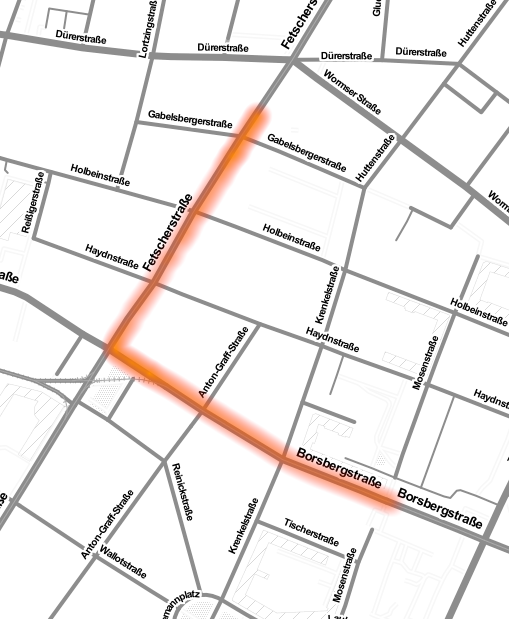

In [15]:
# Display GPS Heatmap from Disk
gpsheatmap = ImageDisp(filename='2014-04-23-GPS-IMU-Data-Heatmap.png')
gpsheatmap

Map tiles by [Stamen Design](http://stamen.com/), under [CC BY 3.0](http://creativecommons.org/licenses/by/3.0/). Data by [OpenStreetMap](http://www.openstreetmap.org/), under [CC BY SA](http://creativecommons.org/licenses/by-sa/3.0/).

## Real Measurements from GNSS Hardware as Ground Truth

In [16]:
datafile = '2014-04-23-GNSSGroundTruth.csv'

LatDD, LonDD = np.loadtxt(datafile, delimiter=',', unpack=True, skiprows=1)

print('Read \'%s\' successfully.' % datafile)

Read '2014-04-23-GNSSGroundTruth.csv' successfully.


## Roll-/Pitch-/Yawrate

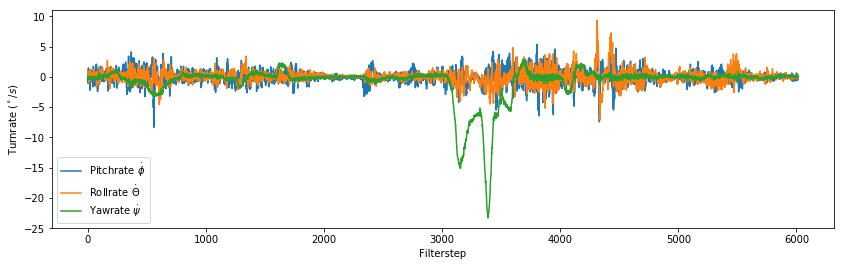

In [17]:
plt.figure(figsize=(14,4))
#plt.plot(roll)
plt.plot(pitchrate, label='Pitchrate $\dot\phi$')
plt.plot(rollrate, label='Rollrate $\dot \Theta$')
plt.plot(yawrate, label='Yawrate $\dot \psi$')
plt.xlabel('Filterstep')
plt.ylabel('Turnrate $(^\circ/s)$')
plt.legend(loc='best')

### Amplitude Spectrum of Turnrates

In [18]:
hann = np.hanning(len(pitchrate))
Yax = np.fft.fft(ax*hann)
Ypitchrate = np.fft.fft(pitchrate*hann)
Yrollrate = np.fft.fft(rollrate*hann)
Yyawrate = np.fft.fft(yawrate*hann)

N   = len(Ypitchrate)/2+1
Xfft = np.linspace(0, 1.0/dt/2, N)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


In [19]:
plt.figure(figsize=(8,3))
plt.plot(Xfft, 2.0*np.abs(Yax[:N])/N, label='Acceleration', alpha=0.9)
plt.plot(Xfft, 2.0*np.abs(Ypitchrate[:N])/N, label='Pitchrate', alpha=0.9)
plt.plot(Xfft, 2.0*np.abs(Yrollrate[:N])/N, label='Rollrate', alpha=0.9)
plt.plot(Xfft, 2.0*np.abs(Yyawrate[:N])/N, label='Yawrate', alpha=0.9)
#plt.xlim(0, 1)
plt.axvline(5, color='grey', label='Cutoff Frequency', alpha=0.4)
plt.legend()
plt.ylabel('Amplitude $^\circ/s /Hz$')
plt.xlabel('Frequency $Hz$')

TypeError: slice indices must be integers or None or have an __index__ method

### 5th Order Butterworth LowPass

In [20]:
cutoff = 5. # Hz
fs = 1/dt
nyq = fs/2.
filterorder = 5

from scipy import signal
b,a = signal.filter_design.butter(filterorder,cutoff/nyq) 

axLowpass = signal.lfilter(b,a, ax)
pitchrateLowpass = signal.lfilter(b,a, pitchrate)
rollrateLowpass = signal.lfilter(b,a, rollrate)
yawrateLowpass = signal.lfilter(b,a, yawrate)

Text(0.5,0,'Filterstep')

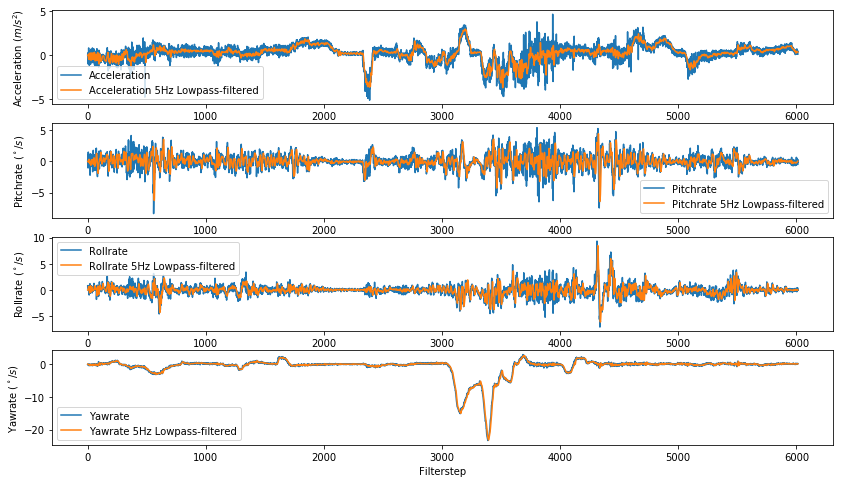

In [21]:
plt.figure(figsize=(14,8))
plt.subplot(411)
plt.plot(ax, label='Acceleration')
plt.plot(axLowpass, label='Acceleration %iHz Lowpass-filtered' % cutoff)
plt.ylabel('Acceleration $(m/s^2)$')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(pitchrate, label='Pitchrate')
plt.plot(pitchrateLowpass, label='Pitchrate %iHz Lowpass-filtered' % cutoff)
plt.ylabel('Pitchrate $(^\circ/s)$')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(rollrate, label='Rollrate')
plt.plot(rollrateLowpass, label='Rollrate %iHz Lowpass-filtered' % cutoff)
plt.ylabel('Rollrate $(^\circ/s)$')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(yawrate, label='Yawrate')
plt.plot(yawrateLowpass, label='Yawrate %iHz Lowpass-filtered' % cutoff)
plt.ylabel('Yawrate $(^\circ/s)$')
plt.legend(loc='best')


plt.xlabel('Filterstep')

### Determine natural Movement Turnrate-Acceleration

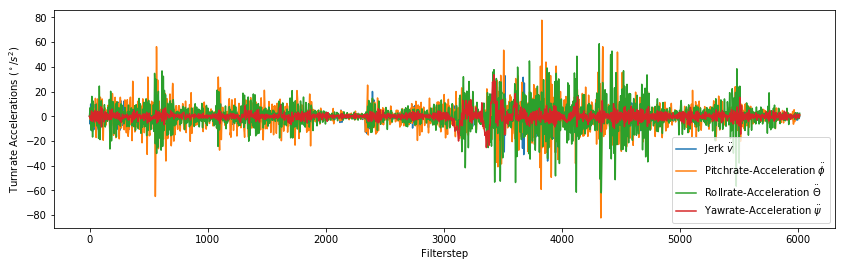

In [22]:
plt.figure(figsize=(14,4))
plt.plot(np.diff(axLowpass)/dt, label='Jerk $\ddot v$')
plt.plot(np.diff(pitchrateLowpass)/dt, label='Pitchrate-Acceleration $\ddot\phi$')
plt.plot(np.diff(rollrateLowpass)/dt, label='Rollrate-Acceleration $\ddot \Theta$')
plt.plot(np.diff(yawrateLowpass)/dt, label='Yawrate-Acceleration $\ddot \psi$')
plt.xlabel('Filterstep')
plt.ylabel('Turnrate Accelerations $(^\circ/s^2)$')
plt.legend()

In [23]:
print('max Jerk: %.1f m/s3' % np.max(np.abs(np.diff(axLowpass)/dt)))
print('max Pitchrate-Acceleration: %.1f °/s2' % np.max(np.abs(np.diff(pitchrateLowpass)/dt)))
print('max Rollrate-Acceleration: %.1f °/s2' % np.max(np.abs(np.diff(rollrateLowpass)/dt)))
print('max Yawrate-Acceleration: %.1f °/s2' % np.max(np.abs(np.diff(yawrateLowpass)/dt)))

max Jerk: 36.2 m/s3
max Pitchrate-Acceleration: 82.3 °/s2
max Rollrate-Acceleration: 62.0 °/s2
max Yawrate-Acceleration: 33.6 °/s2


## Control Input

In [227]:
control = Matrix([axs, dpsis, dphis, dthetas])
control

⎡    aₓ    ⎤
⎢          ⎥
⎢ \dot\psi ⎥
⎢          ⎥
⎢ \dot\phi ⎥
⎢          ⎥
⎣\dot\Theta⎦

In [228]:
print (latex(control))

\left[\begin{matrix}a_{x}\\\dot\psi\\\dot\phi\\\dot\Theta\end{matrix}\right]


### Calculate the Jacobian of the Dynamic Matrix with Respect to the Control Input

In [229]:
JGs = As.jacobian(control)
JGs

⎡   T⋅v⋅cos(T⋅\dot\psi + \psi)   v⋅(-sin(\psi) + sin(T⋅\dot\psi + \psi))      
⎢0  ────────────────────────── - ───────────────────────────────────────  0  0
⎢            \dot\psi                                   2                     
⎢                                               \dot\psi                      
⎢                                                                             
⎢   T⋅v⋅sin(T⋅\dot\psi + \psi)   v⋅(cos(\psi) - cos(T⋅\dot\psi + \psi))       
⎢0  ────────────────────────── - ──────────────────────────────────────   0  0
⎢            \dot\psi                                  2                      
⎢                                              \dot\psi                       
⎢                                                                             
⎢T                                   0                                    0  0
⎢                                                                             
⎢0                                   T              

In [230]:
print (latex(JGs))

\left[\begin{matrix}0 & \frac{T v}{\dot\psi} \cos{\left (T \dot\psi + \psi \right )} - \frac{v}{\dot\psi^{2}} \left(- \sin{\left (\psi \right )} + \sin{\left (T \dot\psi + \psi \right )}\right) & 0 & 0\\0 & \frac{T v}{\dot\psi} \sin{\left (T \dot\psi + \psi \right )} - \frac{v}{\dot\psi^{2}} \left(\cos{\left (\psi \right )} - \cos{\left (T \dot\psi + \psi \right )}\right) & 0 & 0\\T & 0 & 0 & 0\\0 & T & 0 & 0\\0 & 0 & T & 0\\0 & 0 & 0 & T\end{matrix}\right]


## Process Noise Covariance Matrix $Q$

Kelly, A. (1994). A 3D state space formulation of a navigation Kalman filter for autonomous vehicles, (May). Retrieved from http://oai.dtic.mil/oai/oai?verb=getRecord&metadataPrefix=html&identifier=ADA282853: "The state uncertainty model models the disturbances which excite the linear system. Conceptually, it estimates how bad things can get when the system is run open loop for a given period of time.
The $Q$ matrix can be assumed diagonal, and its elements set to the predicted magnitude of the truncated terms in the constant velocity model. They can arise from:

* disturbances such as terrain following loads
* neglected control inputs such as sharp turns, braking or accelerating
* neglected derivatives in the dead reckoning model
* neglected states"

In [231]:
jerkmax = 300.0    # m/s3

pitchrateaccmax=  200.0 *np.pi/180.0 # rad/s2
rollrateaccmax =  200.0 *np.pi/180.0 # rad/s2
yawrateaccmax  =  80.0  *np.pi/180.0 # rad/s2

In [232]:
print('Sigma ax: %.2f m/s2' % (dt * jerkmax))
print('Sigma yaw: %.3f 1/s' % (dt * yawrateaccmax))
print('Sigma pitch: %.3f 1/s' % (dt * pitchrateaccmax))
print('Sigma roll: %.3f 1/s' % (dt * rollrateaccmax))

Sigma ax: 6.00 m/s2
Sigma yaw: 0.028 1/s
Sigma pitch: 0.070 1/s
Sigma roll: 0.070 1/s


In [233]:
Q = np.diagflat([[(dt * jerkmax)**2],            # acceleration
            [(dt * yawrateaccmax)**2],           # yawrate
            [(dt * pitchrateaccmax)**2],         # pitchrate
            [(dt * rollrateaccmax)**2]])         # rollrate

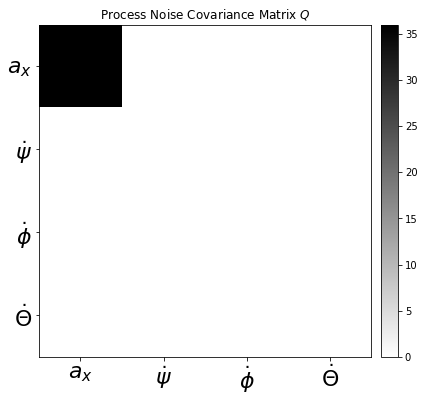

In [234]:
fig = plt.figure(figsize=(numstates, numstates))
im = plt.imshow(Q, interpolation="none", cmap=plt.get_cmap('binary'))
plt.title('Process Noise Covariance Matrix $Q$')
ylocs, ylabels = plt.yticks()
# set the locations of the yticks
plt.yticks(np.arange(6))
# set the locations and labels of the yticks
plt.yticks(np.arange(5), \
           ('$a_x$', '$\dot \psi$', '$\dot \phi$', '$\dot \Theta$'),\
           fontsize=22)

xlocs, xlabels = plt.xticks()
# set the locations of the yticks
plt.xticks(np.arange(6))
# set the locations and labels of the yticks
plt.xticks(np.arange(5), \
           ('$a_x$', '$\dot \psi$', '$\dot \phi$', '$\dot \Theta$'),\
           fontsize=22)

plt.xlim([-0.5,3.5])
plt.ylim([3.5, -0.5])

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
plt.colorbar(im, cax=cax)

plt.tight_layout()

### Estimated Position Error

$EPE \sim \mathrm{HDOP} \cdot \mathrm{URA}(1 \sigma)$

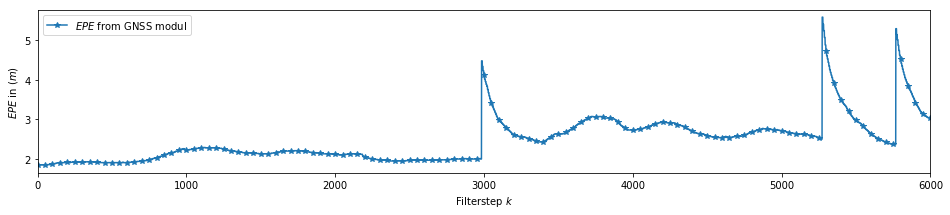

In [235]:
plt.figure(figsize=(16,3))
plt.plot(epe, label='$EPE$ from GNSS modul', marker='*', markevery=50)
#plt.plot(speed)
plt.ylabel('$EPE$ in $(m)$')
plt.xlabel('Filterstep $k$')
plt.xlim(0,6000)
plt.legend(loc='best')
#plt.savefig('Extended-Kalman-Filter-CTRV-Adaptive-R.png', dpi=72, transparent=True, bbox_inches='tight')
plt.savefig('Extended-Kalman-Filter-CTRV-EPE.eps', bbox_inches='tight')

### Lat/Lon to Meters

In [236]:
R = 6378388.0 + altitude # m
arc= 2.0*np.pi*R/360.0 # m/°

dx = arc * np.cos(latitude*np.pi/180.0) * np.hstack((0.0, np.diff(longitude))) # in m
dy = arc * np.hstack((0.0, np.diff(latitude))) # in m

mx = np.cumsum(dx)
my = np.cumsum(dy)

ds = np.sqrt(dx**2+dy**2)

GPS=np.hstack((True, (np.diff(ds)>0.0).astype('bool'))) # GPS Trigger for Kalman Filter

In [237]:
print('One degree of Lon is %.2fkm at %.1fm altitude.' % (arc[0]/1000.0, altitude[0]))

One degree of Lon is 111.33km at 117.7m altitude.


In [238]:
cspeed = []
dtime = []
print(len(millis))
for i in range(len(millis)):
    if i ==0: 
        dtime.append(0)
    else:
        dtime.append(millis[i] - millis[i-1])
        
print(len(dtime))

total_t = 0
total_dx = 0 
total_dy = 0
for i in range(len(dx)):
    if GPS[i]:
        total_t = total_t + dtime[i]
        total_t = total_t/1000
        total_dx = total_dx + dx[i]
        total_dy = total_dy + dy[i]
        
#         print("time:",total_t)
#         print("dx:", total_dx)
        vel = np.sqrt(total_dx**2 + total_dy**2)/total_t 
        if i == 0: 
            vel = 0 
            
#         print(vel)
        total_t = 0 
        total_dx = 0 
        total_dy = 0 
    else:
        total_t = total_t + dtime[i]
        total_dx = total_dx + dx[i]
        total_dy = total_dy + dy[i]
    cspeed.append(vel)

print(len(cspeed))
cspeed = np.array(cspeed)
print(cspeed[0:10])

6014
6014
6014
[ 0.          0.         31.06991234 31.06991234 31.06991234 31.06991234
 31.06991234 11.55868356 11.55868356 11.55868356]


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars


In [239]:
cspeed = []
dtime = []
print(len(millis))
for i in range(len(millis)):
    if i ==0: 
        dtime.append(0)
    else:
        dtime.append(millis[i] - millis[i-1])
        
print(len(dtime))

total_t = 0
total_dx = 0 
total_dy = 0
for i in range(len(dx)):
    if GPS[i]:
        total_t = total_t + dtime[i]
        total_t = total_t/1000
        total_dx = total_dx + dx[i]
        total_dy = total_dy + dy[i]
        
#         print("time:",total_t)
#         print("dx:", total_dx)
        vel = np.sqrt(total_dx**2 + total_dy**2)/total_t 
        if i == 0: 
            vel = 0 
            
#         print(vel)
        total_t = 0 
        total_dx = 0 
        total_dy = 0 
        cspeed.append(vel)
    else:
        total_t = total_t + dtime[i]
        total_dx = total_dx + dx[i]
        total_dy = total_dy + dy[i]

cspeed.append(0)
print(len(cspeed))
cspeed = np.array(cspeed)
print(cspeed[0:10])

6014
6014
1159
[ 0.         31.06991234 11.55868356 11.87006706  9.68999852  9.69626956
 10.05475966 10.12560773  9.6914155  10.69272756]


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars


In [240]:
val = 0 
for i in range(len(GPS)):
    if GPS[i]:
        val = val + 1 
        
print(val)
print(len(cspeed))

sped = []
val = 0 


for i in range(len(GPS)):
    if GPS[i]:
        val = val + 1
#          print(cspeed[val])


    sped.append(cspeed[val])

sped = np.array(sped)
print(sped[0:10])



1158
1159
[31.06991234 31.06991234 11.55868356 11.55868356 11.55868356 11.55868356
 11.55868356 11.87006706 11.87006706 11.87006706]


In [241]:
cspeed = sped

## Measurement Noise Covariance Matrix $R$ (Adaptive)

"In practical use, the uncertainty estimates take on the significance of relative weights of state estimates and measurements. So it is not so much important that uncertainty is absolutely correct as it is that it be relatively consistent across all models" - Kelly, A. (1994). A 3D state space formulation of a navigation Kalman filter for autonomous vehicles, (May). Retrieved from http://oai.dtic.mil/oai/oai?verb=getRecord&metadataPrefix=html&identifier=ADA282853

In [242]:
state

⎡  x   ⎤
⎢      ⎥
⎢  y   ⎥
⎢      ⎥
⎢  v   ⎥
⎢      ⎥
⎢ \psi ⎥
⎢      ⎥
⎢ \phi ⎥
⎢      ⎥
⎣\Theta⎦

In [243]:
R = np.diagflat([[(12.0)**2],      # x
            [(12.0)**2],           # y
            [(1.0)**2],  # v
            [(0.5)**2],  # heading 
            [(0.5)**2],  # pitch
            [(0.5)**2]]) # roll

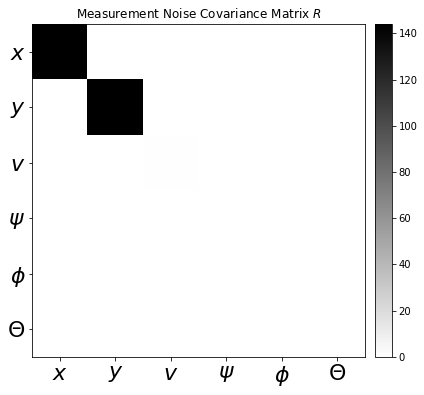

In [244]:
fig = plt.figure(figsize=(numstates, numstates))
im = plt.imshow(R, interpolation="none", cmap=plt.get_cmap('binary'))
plt.title('Measurement Noise Covariance Matrix $R$')
ylocs, ylabels = plt.yticks()
# set the locations of the yticks
plt.yticks(np.arange(7))
# set the locations and labels of the yticks
plt.yticks(np.arange(6), \
           ('$x$', '$y$', '$v$', '$\psi$', '$\phi$', '$\Theta$'),\
           fontsize=22)

xlocs, xlabels = plt.xticks()
# set the locations of the yticks
plt.xticks(np.arange(7))
# set the locations and labels of the yticks
plt.xticks(np.arange(6), \
           ('$x$', '$y$', '$v$', '$\psi$', '$\phi$', '$\Theta$'),\
           fontsize=22)

plt.xlim([-0.5,5.5])
plt.ylim([5.5, -0.5])

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
plt.colorbar(im, cax=cax)

plt.tight_layout()

### Position

$R$ is just initialized here. In the Kalman Filter Step it will calculated dynamically with the $EPE$ (Estimated Position Error) from the GPS signal as well as depending on the $speed$, like proposed in [Wender, S. (2008). Multisensorsystem zur erweiterten Fahrzeugumfelderfassung. Retrieved from http://vts.uni-ulm.de/docs/2008/6605/vts_6605_9026.pdf P.108].

$\sigma_p^2 = c \cdot \sigma_\text{speed}^2 + \sigma_\text{EPE}^2$

with 

$\sigma_\text{speed} = (v+\epsilon)^{-\xi}$

$\sigma_\text{EPE} = \zeta \cdot EPE$

In [274]:
epsilon = 0.1
xi      = 500.0
zeta    = 50.0

## TODO

spspeed=xi/((cspeed/3.6)+epsilon)

#spspeed=xi/((speed/3.6)+epsilon)
# spepe=zeta*epee

spepe=zeta*epe
sp = (spspeed)**2 + (spepe)**2

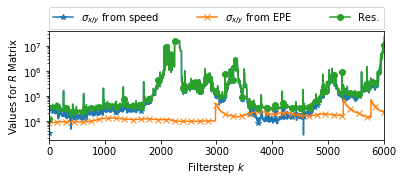

In [275]:
plt.figure(figsize=(6,2))
plt.semilogy(spspeed**2, label='$\sigma_{x/y}$ from speed', marker='*', markevery=150)
plt.semilogy(spepe**2, label='$\sigma_{x/y}$ from EPE', marker='x', markevery=150)
plt.semilogy(sp, label='Res.', marker='o', markevery=150)
plt.ylabel('Values for $R$ Matrix')
plt.xlabel('Filterstep $k$')
plt.xlim(0,6000)
#plt.legend(loc='best')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
       ncol=3, mode="expand", borderaxespad=0.)
#plt.savefig('Extended-Kalman-Filter-CTRV-Adaptive-R.png', dpi=72, transparent=True, bbox_inches='tight')
plt.savefig('Extended-Kalman-Filter-CTRV-Adaptive-R.eps', bbox_inches='tight')

### Attitude

Because the estimation of Roll and Pitch is only valid for quasistatic situations (which is not valid for a moving vehicle), the values for the measured rotations are dynamically chosen.

Uncertainty should be high when car is moving and very low, when the vehicle is standing still

$\sigma_\Theta=\sigma_\psi=\left[\rho+\gamma\cdot a\right]^2$

In [276]:
rho = 200.0
gamma=500.0

sroll = (rho + gamma*ay)**2
spitch= (rho + gamma*ax)**2
syaw = (rho + gamma*az)**2

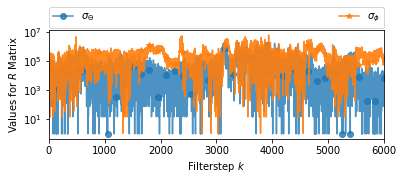

In [277]:
plt.figure(figsize=(6,2))
plt.semilogy(sroll, label='$\sigma_{\Theta}$', marker='o', markevery=150, alpha=0.8)
plt.semilogy(spitch, label='$\sigma_{\phi}$', marker='*', markevery=150, alpha=0.9)
plt.ylabel('Values for $R$ Matrix')
plt.xlabel('Filterstep $k$')
plt.xlim(0,6000)
plt.legend(bbox_to_anchor=(0.0, 1.02, 1., .102), loc=3,
       ncol=2, mode="expand", borderaxespad=0.)
#plt.savefig('Extended-Kalman-Filter-CTRV-Adaptive-R.png', dpi=72, transparent=True, bbox_inches='tight')
plt.savefig('Extended-Kalman-Filter-CTRV-Adaptive-R2.eps', bbox_inches='tight')

## Measurement Function $h$

Matrix H is the Jacobian of the Measurement function h with respect to the state.

#### If GPS Measurement is available

In [278]:
hs = Matrix([[xs],[ys],[vs],[psis],[phis],[thetas]])
Hs=hs.jacobian(state)
Hs

⎡1  0  0  0  0  0⎤
⎢                ⎥
⎢0  1  0  0  0  0⎥
⎢                ⎥
⎢0  0  1  0  0  0⎥
⎢                ⎥
⎢0  0  0  1  0  0⎥
⎢                ⎥
⎢0  0  0  0  1  0⎥
⎢                ⎥
⎣0  0  0  0  0  1⎦

Else set the elements to zero.

### Identity Matrix

In [279]:
I = np.eye(numstates)
print(I, I.shape)

[[1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]] (6, 6)


## Initial State

In [280]:
state

⎡  x   ⎤
⎢      ⎥
⎢  y   ⎥
⎢      ⎥
⎢  v   ⎥
⎢      ⎥
⎢ \psi ⎥
⎢      ⎥
⎢ \phi ⎥
⎢      ⎥
⎣\Theta⎦

## TODO: change this course part to maybe zero?

[[0.        ]
 [0.        ]
 [8.63053121]
 [0.        ]
 [0.        ]
 [0.        ]] (6, 1)


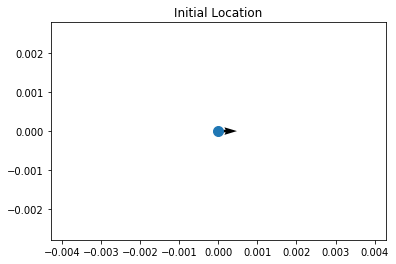

In [281]:
# x = np.matrix([[mx[0], my[0], speed[0]/3.6, course[0]/180.0*np.pi+0.05, 0.0, 0.0]]).T
x = np.matrix([[mx[0], my[0], cspeed[0]/3.6, 0.0, 0.0, 0.0]]).T
print(x, x.shape)

U=float(np.cos(x[3])*x[2])
V=float(np.sin(x[3])*x[2])

plt.quiver(x[0], x[1], U, V)
plt.scatter(float(x[0]), float(x[1]), s=100)
plt.title('Initial Location')
plt.axis('equal')

## Initial Uncertainty

Initialized with $0$ means you are pretty sure where the vehicle starts and in which direction it is heading. Initialized with high values means, that you trust the measurements first, to align the state vector $x$ with them.

(6, 6)


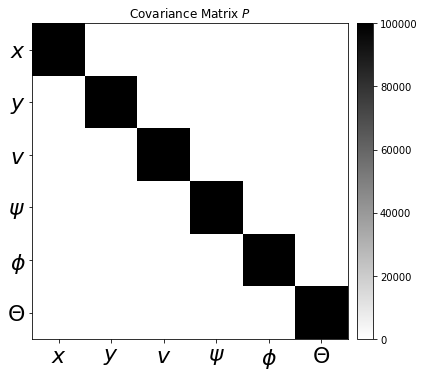

In [282]:
P = 1e5*np.eye(numstates)
print(P.shape)

fig = plt.figure(figsize=(numstates, numstates))
im = plt.imshow(P, interpolation="none", cmap=plt.get_cmap('binary'))
plt.title('Covariance Matrix $P$')
ylocs, ylabels = plt.yticks()
# set the locations of the yticks
plt.yticks(np.arange(7))
# set the locations and labels of the yticks
plt.yticks(np.arange(6), \
           ('$x$', '$y$', '$v$', '$\psi$', '$\phi$', '$\Theta$'),\
           fontsize=22)

xlocs, xlabels = plt.xticks()
# set the locations of the yticks
plt.xticks(np.arange(7))
# set the locations and labels of the yticks
plt.xticks(np.arange(6), \
           ('$x$', '$y$', '$v$', '$\psi$', '$\phi$', '$\Theta$'),\
           fontsize=22)

plt.xlim([-0.5,5.5])
plt.ylim([5.5, -0.5])

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
plt.colorbar(im, cax=cax)

plt.tight_layout()

## Put everything together as a measurement vector

In [283]:
state

⎡  x   ⎤
⎢      ⎥
⎢  y   ⎥
⎢      ⎥
⎢  v   ⎥
⎢      ⎥
⎢ \psi ⎥
⎢      ⎥
⎢ \phi ⎥
⎢      ⎥
⎣\Theta⎦

## TODO: assume there is no heading measurment

In [284]:
# measurements = np.vstack((mx, my, \
#                           speed/3.6, \
#                           (((course+180.0)%360.0-180.0))/180.0*np.pi, \
#                           pitch/180.0*np.pi, \
#                           roll/180.0*np.pi))

measurements = np.vstack((mx, my, \
                          cspeed/3.6, \
                          yaw/180.0*np.pi, \
                          pitch/180.0*np.pi, \
                          roll/180.0*np.pi))

# Lenth of the measurement
m = measurements.shape[1]
print(measurements.shape)

(6, 6014)


In [285]:
# Preallocation for Plotting
x0 = []
x1 = []
x2 = []
x3 = []
x4 = []
x5 = []
x6 = []
x7 = []
x8 = []
Zx = []
Zy = []
P0 = []
P1 = []
P2 = []
P3 = []
P4 = []
P5 = []
P6 = []
P7 = []
P8 = []
K0 = []
K1 = []
K2 = []
K3 = []
K4 = []
K5 = []
dstate=[]

In [286]:
starttime = time.time()

# Extended Kalman Filter Step

$$x_k= \left[ \begin{matrix} x\\y\\ v \\ \psi\\\phi\\\Theta \end{matrix}\right] = \left[ \begin{matrix} \text{Position x} \\ \text{Position y} \\ \text{Speed} \\ \text{Heading} \\ \text{Pitch} \\ \text{Roll} \end{matrix}\right] =  \underbrace{\begin{matrix}x[0] \\ x[1] \\ x[2] \\ x[3] \\ x[4] \\ x[5] \end{matrix}}_{\textrm{Python Nomenclature}}$$

In [287]:
for filterstep in range(m):

    axc = -ax[filterstep]
    yawc = yawrate[filterstep]/180.0*np.pi
    pitc = pitchrate[filterstep]/180.0*np.pi
    rolc = rollrate[filterstep]/180.0*np.pi
    
    # Time Update (Prediction)
    # ========================
    # Project the state ahead
    # see "Dynamic Matrix"
    if yawc==0.0: # Driving straight
        x[0] = x[0] + x[2]*dt * np.cos(x[3])
        x[1] = x[1] + x[2]*dt * np.sin(x[3])
        x[2] = x[2] + axc*dt
        x[3] = x[3]
        x[4] = x[4] + pitc*dt
        x[5] = x[5] + rolc*dt
        yawc = 0.00000001 # to avoid numerical issues in Jacobians
        dstate.append(0)
    else: # otherwise
        x[0] = x[0] + (x[2]/yawc) * (np.sin(yawc*dt+x[3]) - np.sin(x[3]))
        x[1] = x[1] + (x[2]/yawc) * (-np.cos(yawc*dt+x[3])+ np.cos(x[3]))
        x[2] = x[2] + axc*dt
        x[3] = (x[3] + yawc*dt + np.pi) % (2.0*np.pi) - np.pi
        x[4] = x[4] + pitc*dt
        x[5] = x[5] + rolc*dt
        dstate.append(1)
    
    # Calculate the Jacobian of the Dynamic Matrix A
    # see "Calculate the Jacobian of the Dynamic Matrix with respect to the state vector"
    a13 = float((1.0/yawc) * (np.sin(yawc*dt+x[3]) - np.sin(x[3])))
    a14 = float((x[2]/yawc)* (np.cos(yawc*dt+x[3]) - np.cos(x[3])))
    a23 = float((1.0/yawc) * (-np.cos(yawc*dt+x[3]) + np.cos(x[3])))
    a24 = float(x[2]/yawc) * (np.sin(yawc*dt+x[3]) - np.sin(x[3]))
    JA = np.matrix([[1.0, 0.0, a13, a14, 0.0, 0.0],
                  [0.0, 1.0, a23, a24, 0.0, 0.0],
                  [0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
                  [0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
                  [0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
                  [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]])
    
    # Calculate the Jacobian of the Control Input G
    # see "Calculate the Jacobian of the Dynamic Matrix with Respect to the Control"
    g12 = float((dt*x[2]/yawc)*np.cos(yawc*dt+x[3]) - x[2]/yawc**2*(np.sin(yawc*dt+x[3])-np.sin(x[3])))
    g22 = float((dt*x[2]/yawc)*np.sin(yawc*dt+x[3]) - x[2]/yawc**2*(-np.cos(yawc*dt+x[3])+np.cos(x[3])))
    JG = np.matrix([[0.0, g12, 0.0, 0.0],
                    [0.0, g22, 0.0, 0.0],
                    [dt, 0.0, 0.0, 0.0],
                    [0.0, dt, 0.0, 0.0],
                    [0.0, 0.0, dt, 0.0],
                    [0.0, 0.0, 0.0, dt]])
 
    # Project the error covariance ahead
    P = JA*P*JA.T + JG*Q*JG.T
    
    
    # Measurement Update (Correction)
    # ===============================
    hx = np.matrix([[float(x[0])],
                    [float(x[1])],
                    [float(x[2])],                    
                    [float(x[3])],
                    [float(x[4])],
                    [float(x[5])]])
    # Because GPS is sampled with 10Hz and the other Measurements, as well as
    # the filter are sampled with 50Hz, one have to wait for correction until
    # there is a new GPS Measurement
    if GPS[filterstep]:
        # Calculate the Jacobian of the Measurement Function
        # see "Measurement Matrix H"
        JH = np.matrix([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                        [0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
                        [0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
                        [0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
                        [0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
                        [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]])
    else:
        # Calculate the Jacobian of the Measurement Function
        # see "Measurement Matrix H"
        JH = np.matrix([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                        [0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
                        [0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
                        [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]])
    
    # Adaptive R
    R[0,0] = sp[filterstep]       # x
    R[1,1] = sp[filterstep]       # y
    R[2,2] = spspeed[filterstep]  # v
    R[3,3] = syaw[filterstep]  # course
    R[4,4] = spitch[filterstep]   # pitch
    R[5,5] = sroll[filterstep]    # roll
    

    S = JH*P*JH.T + R
    K = (P*JH.T) * np.linalg.inv(S)

    # Update the estimate via
    z = measurements[:,filterstep].reshape(JH.shape[0],1)
    y = z - (hx)                         # Innovation or Residual
    x = x + (K*y)
    
    # Update the error covariance
    P = (I - (K*JH))*P
    

    # Save states for Plotting
    x0.append(float(x[0]))
    x1.append(float(x[1]))
    x2.append(float(x[2]))
    x3.append(float(x[3]))
    x4.append(float(x[4]))
    x5.append(float(x[5]))

    P0.append(float(P[0,0]))
    P1.append(float(P[1,1]))
    P2.append(float(P[2,2]))
    P3.append(float(P[3,3]))
    P4.append(float(P[4,4]))
    P5.append(float(P[5,5]))
    
    #Zx.append(float(z[0]))
    #Zy.append(float(z[1]))    
    
    K0.append(float(K[0,0]))
    K1.append(float(K[1,0]))
    K2.append(float(K[2,0]))
    K3.append(float(K[3,0]))
    K4.append(float(K[4,0]))

In [288]:
print('One Filterstep took %.4fs (average) on MacBook Pro 2.5GHz Intel i5' % ((time.time() - starttime)/m))

One Filterstep took 0.0007s (average) on MacBook Pro 2.5GHz Intel i5


# Plots

In [289]:
%pylab inline --no-import-all

Populating the interactive namespace from numpy and matplotlib


## Uncertainties of Matrix $P$

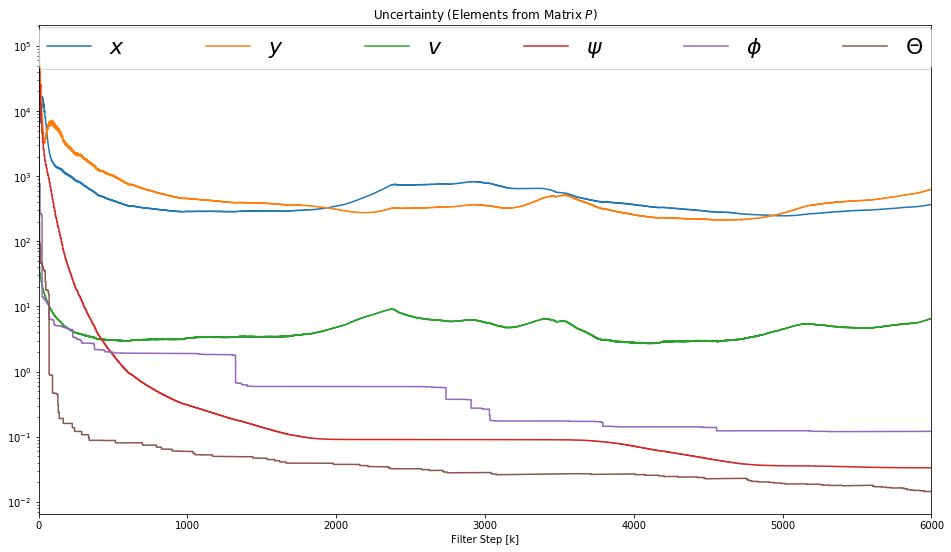

In [290]:
fig = plt.figure(figsize=(16,9))
plt.semilogy(range(m),P0, label='$x$')
plt.step(range(m),P1, label='$y$')
plt.step(range(m),P2, label='$v$')
plt.step(range(m),P3, label='$\psi$')
plt.step(range(m),P4, label='$\phi$')
plt.step(range(m),P5, label='$\Theta$')

plt.xlabel('Filter Step [k]')
plt.ylabel('')
plt.xlim(0,6000)
plt.title('Uncertainty (Elements from Matrix $P$)')
#plt.legend(loc='best',prop={'size':22})
plt.legend(bbox_to_anchor=(0., 0.91, 1., .06), loc=3,
       ncol=9, mode="expand", borderaxespad=0.,prop={'size':22})
plt.savefig('Covariance-Matrix-Verlauf.eps', bbox_inches='tight')

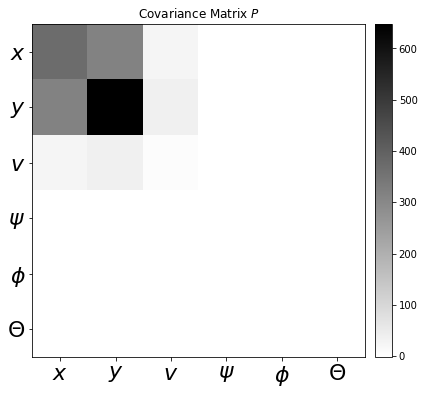

In [291]:
fig = plt.figure(figsize=(numstates, numstates))
im = plt.imshow(P, interpolation="none", cmap=plt.get_cmap('binary'))
plt.title('Covariance Matrix $P$')
ylocs, ylabels = plt.yticks()
# set the locations of the yticks
plt.yticks(np.arange(7))
# set the locations and labels of the yticks
plt.yticks(np.arange(6), \
           ('$x$', '$y$', '$v$', '$\psi$', '$\phi$', '$\Theta$'),\
           fontsize=22)

xlocs, xlabels = plt.xticks()
# set the locations of the yticks
plt.xticks(np.arange(7))
# set the locations and labels of the yticks
plt.xticks(np.arange(6), \
           ('$x$', '$y$', '$v$', '$\psi$', '$\phi$', '$\Theta$'),\
           fontsize=22)

plt.xlim([-0.5,5.5])
plt.ylim([5.5, -0.5])

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
plt.colorbar(im, cax=cax)

plt.tight_layout()

## Kalman Gains in $K$

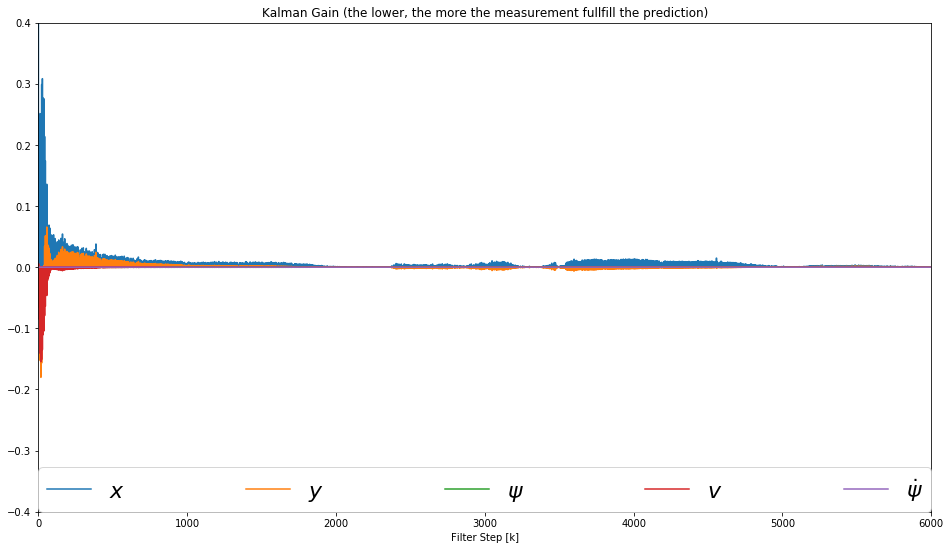

In [292]:
fig = plt.figure(figsize=(16,9))
plt.step(range(len(measurements[0])),K0, label='$x$')
plt.step(range(len(measurements[0])),K1, label='$y$')
plt.step(range(len(measurements[0])),K2, label='$\psi$')
plt.step(range(len(measurements[0])),K3, label='$v$')
plt.step(range(len(measurements[0])),K4, label='$\dot \psi$')

plt.xlabel('Filter Step [k]')
plt.ylabel('')
plt.xlim(0,6000)
plt.title('Kalman Gain (the lower, the more the measurement fullfill the prediction)')
#plt.legend(prop={'size':18})
plt.legend(bbox_to_anchor=(0., 0., 1., .102), loc=3,
       ncol=5, mode="expand", borderaxespad=0.,prop={'size':22})
plt.ylim([-0.4,0.4])

## State Vector

In [293]:
state

⎡  x   ⎤
⎢      ⎥
⎢  y   ⎥
⎢      ⎥
⎢  v   ⎥
⎢      ⎥
⎢ \psi ⎥
⎢      ⎥
⎢ \phi ⎥
⎢      ⎥
⎣\Theta⎦

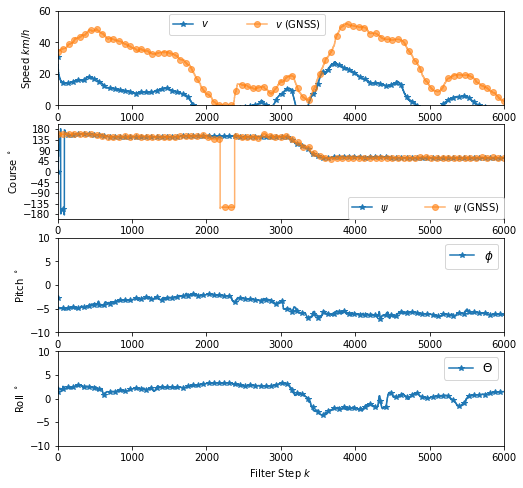

In [294]:
fig = plt.figure(figsize=(8,numstates+2))

# Speed
plt.subplot(411)
plt.step(range(len(measurements[0])),np.multiply(x2,3.6), label='$v$', marker='*', markevery=140)
plt.step(range(len(measurements[0])),speed, label='$v$ (GNSS)', marker='o', markevery=150, alpha=0.6)
plt.ylabel('Speed $km/h$')
plt.xlim(0,6000)
#plt.yticks(np.arange(-180, 181, 45))
plt.ylim([0,60])
plt.legend(bbox_to_anchor=(0.25, 0.75, 0.35, .06), loc=3,
       ncol=2, mode="expand", borderaxespad=0.)

# Course
plt.subplot(412)
plt.step(range(len(measurements[0])),np.multiply(x3,180.0/np.pi), label='$\psi$', marker='*', markevery=140)
plt.step(range(len(measurements[0])),(course+180.0)%(360.0)-180.0, label='$\psi$ (GNSS)', marker='o', markevery=150, alpha=0.6)
plt.ylabel('Course $^\circ$')
plt.yticks(np.arange(-180, 181, 45))
plt.ylim([-200,200])
plt.xlim(0,6000)
plt.legend(bbox_to_anchor=(0.65, 0.0, 0.35, .06), loc=3,
       ncol=2, mode="expand", borderaxespad=0.)
#plt.title('State Estimates $x_k$')

# Pitch
plt.subplot(413)
plt.step(range(len(measurements[0])),np.multiply(x4,180.0/np.pi), label='$\phi$', marker='*', markevery=140)
plt.ylabel('Pitch $^\circ$')
plt.ylim([-10.0, 10.0])
plt.xlim(0,6000)
plt.legend(loc='best',prop={'size':12})

# Roll
plt.subplot(414)
plt.step(range(len(measurements[0])),np.multiply(x5,180.0/np.pi), label='$\Theta$', marker='*', markevery=140)
plt.ylabel('Roll $^\circ$')
plt.ylim([-10.0, 10.0])
plt.xlim(0,6000)
plt.legend(loc='best',prop={'size':12})

plt.xlabel('Filter Step $k$')

plt.savefig('Extended-Kalman-Filter-CTRV-Attitude-State-Estimates.eps', bbox_inches='tight')

In [295]:
#%pylab --no-import-all

### Convert back from Meters to Lat/Lon (WGS84)

In [296]:
latekf = latitude[0] + np.divide(x1,arc)
lonekf = longitude[0]+ np.divide(x0,np.multiply(arc,np.cos(latitude*np.pi/180.0)))

## Position Lat/Lon

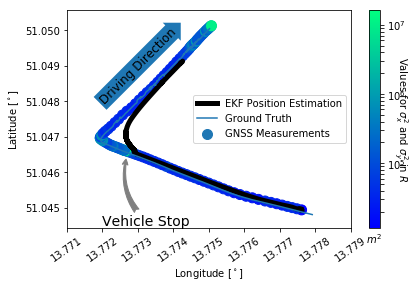

In [297]:
whratio = np.cos(np.mean(latitude*np.pi/180.0))
fh = 4.0
fig = plt.figure(figsize=(fh/whratio, fh))

# EKF State
plt.plot(lonekf,latekf, label='EKF Position Estimation', color='k', linewidth=5)

# Ground Truth
plt.plot(LonDD,LatDD, label='Ground Truth')

# Low Cost GPS Measurements
plt.scatter(longitude[::50],latitude[::50], s=100, label='GNSS Measurements',\
            c=sp[::50], cmap='winter', norm=matplotlib.colors.LogNorm())
cbar=plt.colorbar()
cbar.ax.set_ylabel(u'Values for $\sigma_x^2$ and $\sigma_y^2$ in $R$', rotation=270)
cbar.ax.set_xlabel(u'$m^2$')

# Annotations
bbox_props = dict(boxstyle="rarrow,pad=0.3", ec="w", lw=2)
t = plt.text(13.773, 51.049, "Driving Direction", ha="center", va="center", rotation=45,
            size=12,
            bbox=bbox_props)


plt.annotate("Vehicle Stop",
            xy=(13.7727, 51.0465), xycoords='data',
            xytext=(13.772, 51.0445), textcoords='data',
            size=14,
            arrowprops=dict(arrowstyle="fancy", #linestyle="dashed",
                            color="0.5",
                            shrinkB=5,
                            connectionstyle="arc3,rad=-0.3",
                            ),
            )

plt.xlabel('Longitude [$^\circ$]')
plt.ylabel('Latitude [$^\circ$]')
#plt.title('Position of EKF state $x_k$, GNSS measurements and uncertainty $R$ (color)')
plt.legend(loc='best')
plt.axis('equal')
#plt.tight_layout()

#plt.xlim(13.7865, 13.7880)
#plt.ylim(51.0265, 51.0285)

# xticks
locs,labels = plt.xticks()
plt.xticks(locs, map(lambda x: "%.3f" % x, locs))
plt.xticks(rotation=35)

# ytikcs
locs,labels = plt.yticks()
plt.yticks(locs, map(lambda x: "%.3f" % x, locs))

#plt.show()
plt.savefig('Extended-Kalman-Filter-CTRV-Position.eps', bbox_inches='tight')

## Detail View of the Stop

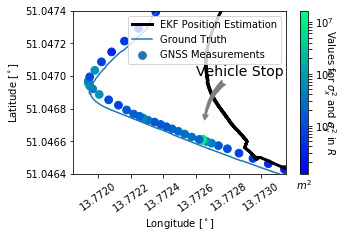

In [298]:
whratio = np.cos(np.mean(latitude*np.pi/180.0))
fh = 3.0
fig = plt.figure(figsize=(fh/whratio, fh))

# EKF State
plt.plot(lonekf,latekf, label='EKF Position Estimation', color='k', linewidth=3)

# Ground Truth
plt.plot(LonDD,LatDD, label='Ground Truth')

# Low Cost GPS Measurements
plt.scatter(longitude[::50],latitude[::50], s=60, label='GNSS Measurements',\
            c=sp[::50], cmap='winter', norm=matplotlib.colors.LogNorm())
cbar=plt.colorbar()
cbar.ax.set_ylabel(u'Values for $\sigma_x^2$ and $\sigma_y^2$ in $R$', rotation=270)
cbar.ax.set_xlabel(u'$m^2$')

# Annotations
plt.annotate("Vehicle Stop",
            xy=(13.77265, 51.0467), xycoords='data',
            xytext=(13.7726, 51.047), textcoords='data',
            size=14,
            arrowprops=dict(arrowstyle="fancy", #linestyle="dashed",
                            color="0.5",
                            shrinkB=5,
                            connectionstyle="arc3,rad=0.3",
                            ),
            )

plt.xlabel('Longitude [$^\circ$]')
plt.ylabel('Latitude [$^\circ$]')
#plt.title('Position of EKF state $x_k$, GNSS measurements and uncertainty $R$ (color)')
plt.legend(loc='best')
plt.axis('equal')
#plt.tight_layout()

plt.xlim(13.772, 13.773)
plt.ylim(51.0465, 51.0474)

# xticks
locs,labels = plt.xticks()
plt.xticks(locs, map(lambda x: "%.4f" % x, locs))
plt.xticks(rotation=35)

# ytikcs
locs,labels = plt.yticks()
plt.yticks(locs, map(lambda x: "%.4f" % x, locs))

#plt.show()
plt.savefig('Extended-Kalman-Filter-CTRV-Position-Detail.eps', bbox_inches='tight')

In [299]:
print('Done.')

Done.


# Conclusion

As you can see, complicated analytic calculation of the Jacobian Matrices, but it works pretty well.

Let's take a look at the trajectory on Google Earth:

## Write Google Earth KML

Coordinates and timestamps to be used to locate the car model in time and space
The value can be expressed as yyyy-mm-ddThh:mm:sszzzzzz, where T is the separator between the date and the time, and the time zone is either Z (for UTC) or zzzzzz, which represents ±hh:mm in relation to UTC.

In [300]:
import datetime
car={}
car['when']=[]
car['coord']=[]
car['gps']=[]
for i in range(len(millis)):
    d=datetime.datetime.fromtimestamp(millis[i]/1000.0)
    car["when"].append(d.strftime("%Y-%m-%dT%H:%M:%SZ"))
    car["coord"].append((lonekf[i], latekf[i], 0))
    car["gps"].append((longitude[i], latitude[i], 0))

In [301]:
from simplekml import Kml, Model, AltitudeMode, Orientation, Scale

ModuleNotFoundError: No module named 'simplekml'

In [ ]:
# The model path and scale variables
car_dae = r'http://simplekml.googlecode.com/hg/samples/resources/car-model.dae'
car_scale = 1.0

# Create the KML document
kml = Kml(name=d.strftime("%Y-%m-%d %H:%M"), open=1)

# Create the model
model_car = Model(altitudemode=AltitudeMode.clamptoground,
                            orientation=Orientation(heading=75.0),
                            scale=Scale(x=car_scale, y=car_scale, z=car_scale))

# Create the track
trk = kml.newgxtrack(name="EKF", altitudemode=AltitudeMode.clamptoground,
                     description="State Estimation from Extended Kalman Filter with CTRV Model")
gps = kml.newgxtrack(name="GPS", altitudemode=AltitudeMode.clamptoground,
                     description="Original GPS Measurements")

# Attach the model to the track
trk.model = model_car
#gps.model = model_car

trk.model.link.href = car_dae
#gps.model.link.href = car_dae

# Add all the information to the track
trk.newwhen(car["when"])
trk.newgxcoord(car["coord"])

gps.newwhen(car["when"][::5])
gps.newgxcoord((car["gps"][::5]))

# Style of the Track
trk.iconstyle.icon.href = ""
trk.labelstyle.scale = 1
trk.linestyle.width = 10
trk.linestyle.color = '7f00ff00' # aabbggrr

gps.iconstyle.icon.href = ""
gps.labelstyle.scale = 0
gps.linestyle.width = 4
gps.linestyle.color = '7fff0000'


# Saving
#kml.save("Extended-Kalman-Filter-CTRV.kml")
kml.savekmz("Extended-Kalman-Filter-CTRV-Adaptive.kmz")

In [ ]:
print('Exported KMZ File for Google Earth')

Works just fine!

<img style="float: right" src="http://ragefaces.s3.amazonaws.com/4cd57c0f873a3d1965122d749a539e98.png" />